In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import h5py
import hdf5plugin
import numpy

## Create 2D VDS over 3D .npy file

In [3]:
import struct

def npy_to_h5dataset(npyfilename, group, name):
    """Create a HDF5 dataset to access a .npy file

    :param str npyfilename: Name of the .npy file.
        WARNING: This filename is used as is to reference the .npy file
        from the HDF5 file! Beware of absolute/relative path use.
    :param h5py.Group group: HDF5 group where to create the dataset
    :pram str name: Name of the HDF5 dataset
    """
    with open(npyfilename, mode='rb') as f:
        header = struct.unpack('6sBB', f.read(8))
        assert header == (b'\x93NUMPY', 1, 0)
        length = struct.unpack('<H', f.read(2))[0]
        f.seek(8)  # Seek back to end of magic header
        shape, fortran_order, dtype = numpy.lib.format.read_array_header_1_0(f)        
        assert not fortran_order

    # Offset in bytes of the array
    offset = length + 10
    # Size in bytes of the array
    size = numpy.prod(shape) * dtype.itemsize
    
    return group.create_dataset(
        name,
        shape=shape,
        dtype=dtype,
        external=[(os.path.abspath(npyfilename), offset, offset + size)])

In [4]:
# Create HDF5 file a 3D external dataset stored in a .npy file and a 2D VDS mapping over it 
with h5py.File("/media/nvme/tvincent/testhdf5.h5", mode="w") as f:
    # Add stack of images
    images = npy_to_h5dataset('/media/nvme/tvincent/wasps_full.npy', f, 'images')

    # Prepare VDS layout
    assert images.ndim == 3
    nbimgs = int(numpy.sqrt(images.shape[0]))
    shape = nbimgs * images.shape[1], nbimgs * images.shape[2]

    layout = h5py.VirtualLayout(shape=shape, dtype=images.dtype)
    source = h5py.VirtualSource(images)
    for row in range(nbimgs):
        for col in range(nbimgs):
            layout[row*images.shape[1]:(row+1)*images.shape[1],
                   col*images.shape[2]:(col+1)*images.shape[2]] = source[row * nbimgs + col]

    # Create VDS
    f.create_virtual_dataset('level0', layout, fillvalue=0)

## Create binned levels

In [6]:
def binning(image):
    assert image.ndim == 2
    return 0.25 * (image[:-1:2, :-1:2] + image[:-1:2, 1::2] + image[1::2, :-1:2] + image[1::2, 1::2])

def create_binned_level(group, name, previous, chunk=None):
    """Create a new HDF5 dataset with previous data binned 2x2

    :param h5py.Group group:
    :param str name:
    :param Union[h5py.Dataset,numpy.ndarray] previous:
    :param Union[None,List[int]] chunk:
        If not None run process by chunks.
        Chunk is defined in the output space.
    """
    if chunk is None:
        group[name] = binning(previous[()])
        return group[name]

    assert previous.ndim == 2
    shape = previous.shape[0] // 2, previous.shape[1] // 2
    dataset = group.create_dataset(
        name, shape=shape, dtype=previous.dtype)

    for row in range(shape[0] // chunk[0] + numpy.sign(shape[0] % chunk[0])):
        for col in range(shape[1] // chunk[1] + numpy.sign(shape[1] % chunk[1])):
            rbegin, rend = row * chunk[0], (row + 1) * chunk[0]
            cbegin, cend = col * chunk[1], (col + 1) * chunk[1]
            dataset[rbegin:rend, cbegin:cend] = binning(previous[rbegin*2:rend*2, cbegin*2:cend*2])

    return dataset

In [7]:
with h5py.File("/media/nvme/tvincent/testhdf5.h5", mode="a") as f:
    for index in range(1, 8):
        print('Index', index)
        create_binned_level(f, 'level%s' % index, previous=f['level%s' % (index-1)], chunk=(1024, 1024))

Index 1
Index 2
Index 3
Index 4
Index 5
Index 6
Index 7


(2099, 3445, 3445) float16
(155025, 155025) float16
(1211, 1211) float16


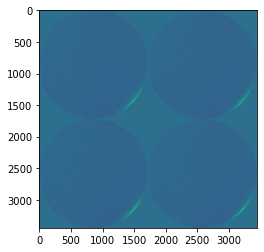

In [8]:
with h5py.File("/media/nvme/tvincent/testhdf5.h5", mode="r") as f:
    print(f['images'].shape, f['images'].dtype)
    print(f['level0'].shape, f['level0'].dtype)
    print(f['level7'].shape, f['level7'].dtype)
    #plt.imshow(f['images'][1000].astype('float32'))
    plt.imshow(f['level1'][:3445, :3445].astype('float32'))

## Update pyramid in live

In [10]:
def binning(image):
    assert image.ndim == 2
    return 0.25 * (image[:-1:2, :-1:2] + image[:-1:2, 1::2] + image[1::2, :-1:2] + image[1::2, 1::2])

def update_binned_levels(levels, previous, rbegin, rend, cbegin, cend):
    """Update sub-region of a pyramid of image

    :param List[Union[h5py.Dataset,numpy.ndarray]] levels:
        Iterable of pyramid levels to update from largest to smallest.
    :param Union[h5py.Dataset,numpy.ndarray] previous:
        Updated level which is the one before the first one of levels.
    :param int rbegin:
    :param int rend:
    :param int cbegin:
    :param int cend:
    """
    for level in levels:
        print(level)
        # Start and end on even index, eventually enlarging the area 
        if rbegin % 2 != 0:
            rbegin -= 1
        if rend % 2 != 0:
            rend += 1
        if cbegin % 2 != 0:
            cbegin -= 1
        if cend % 2 != 0:
            cend += 1

        # TODO maybe fails on the edges
        level[rbegin//2:rend//2, cbegin//2:cend//2] = binning(previous[rbegin:rend, cbegin:cend])
        rbegin //= 2
        rend //= 2
        cbegin //= 2
        cend //= 2
        previous = level


In [38]:
%%time

# Faster for smaller chunks, what else

with h5py.File("/media/nvme/tvincent/testhdf5.h5", mode="a") as f:
    for index in range(4):
        rbegin, rend = 2048*index, 2048*(index+1)
        cbegin, cend = 2048*index, 2048*(index+1)

        update_binned_levels(
            levels=[f['level%d' % i] for i in range(1, 8)],
            previous=f['level0'],
            rbegin=rbegin,
            rend=rend,
            cbegin=cbegin,
            cend=cend)


CPU times: user 396 ms, sys: 210 ms, total: 605 ms
Wall time: 631 ms


In [34]:
1000./2**14*2048

125.0

In [36]:
0.173/2048**2

4.124641418457031e-08